In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tikzplotlib

In [22]:
def bootstrapping(data, num_per_group, num_of_group):
    new_data = np.array([np.mean(np.random.choice(data, num_per_group, replace=True)) for _ in range(num_of_group)])
    return new_data

def generate_confidence_interval(ys, number_per_g = 30, number_of_g = 1000, low_percentile = 1, high_percentile = 99):
    means = []
    mins =[]
    maxs = []
    for i,y in enumerate(ys.T):
        y = bootstrapping(y, number_per_g, number_of_g)
        means.append(np.mean(y))
        mins.append(np.percentile(y, low_percentile))
        maxs.append(np.percentile(y, high_percentile))
    return np.array(means), np.array(mins), np.array(maxs)

def plot_ci(x, y, num_runs, num_dots, mylegend,ls='-', lw=3, transparency=0.2):
    assert(x.ndim==1)
    assert(x.size==num_dots)
    assert(y.ndim==2)
    assert(y.shape==(num_runs,num_dots))
    y_mean, y_min, y_max = generate_confidence_interval(y)
    plt.plot(x, y_mean, 'o-', label=mylegend, linestyle=ls, linewidth=lw) #, label=r'$\alpha$={}'.format(alpha))
    plt.fill_between(x, y_min, y_max, alpha=transparency)
    return

def unpack_data(directory_path, datatype='losses.log', epochs=200, num_workers=10):
    directory = os.path.join(directory_path)
    if not os.path.isdir(directory):
        raise Exception(f"custom no directory {directory}")
    data = np.zeros((epochs, num_workers))
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(datatype):
                j = int(file.split('-')[0][1:])
                with open(directory_path + '/' + file, 'r') as f:
                    i = 0
                    for line in f:
                        data[i, j] = line
                        i += 1
    return data

def time_order(directory_path, epochs=200, num_workers=10):

    time_data = unpack_data(directory_path, datatype='total-time.log', epochs=epochs, num_workers=num_workers)
    time_data = np.cumsum(time_data/60, axis=0)
    time_data = time_data.flatten()
    sorted_time = np.argsort(time_data)
    selected_workers = sorted_time[(num_workers-1)::num_workers]
    time_stamps = time_data[selected_workers]
    # print(time_stamps)
    
    return time_stamps, sorted_time

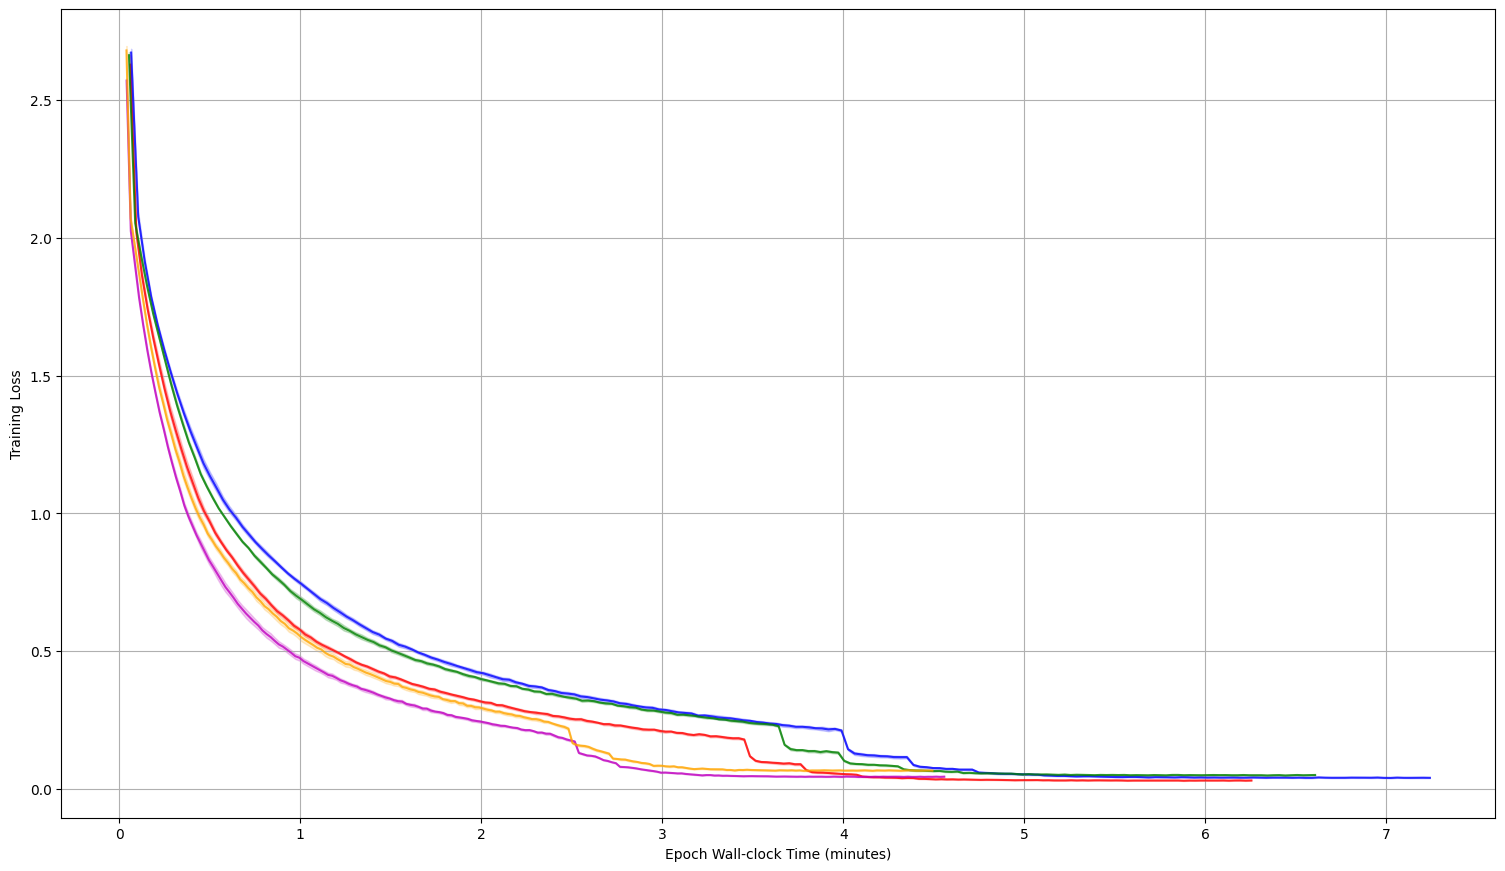

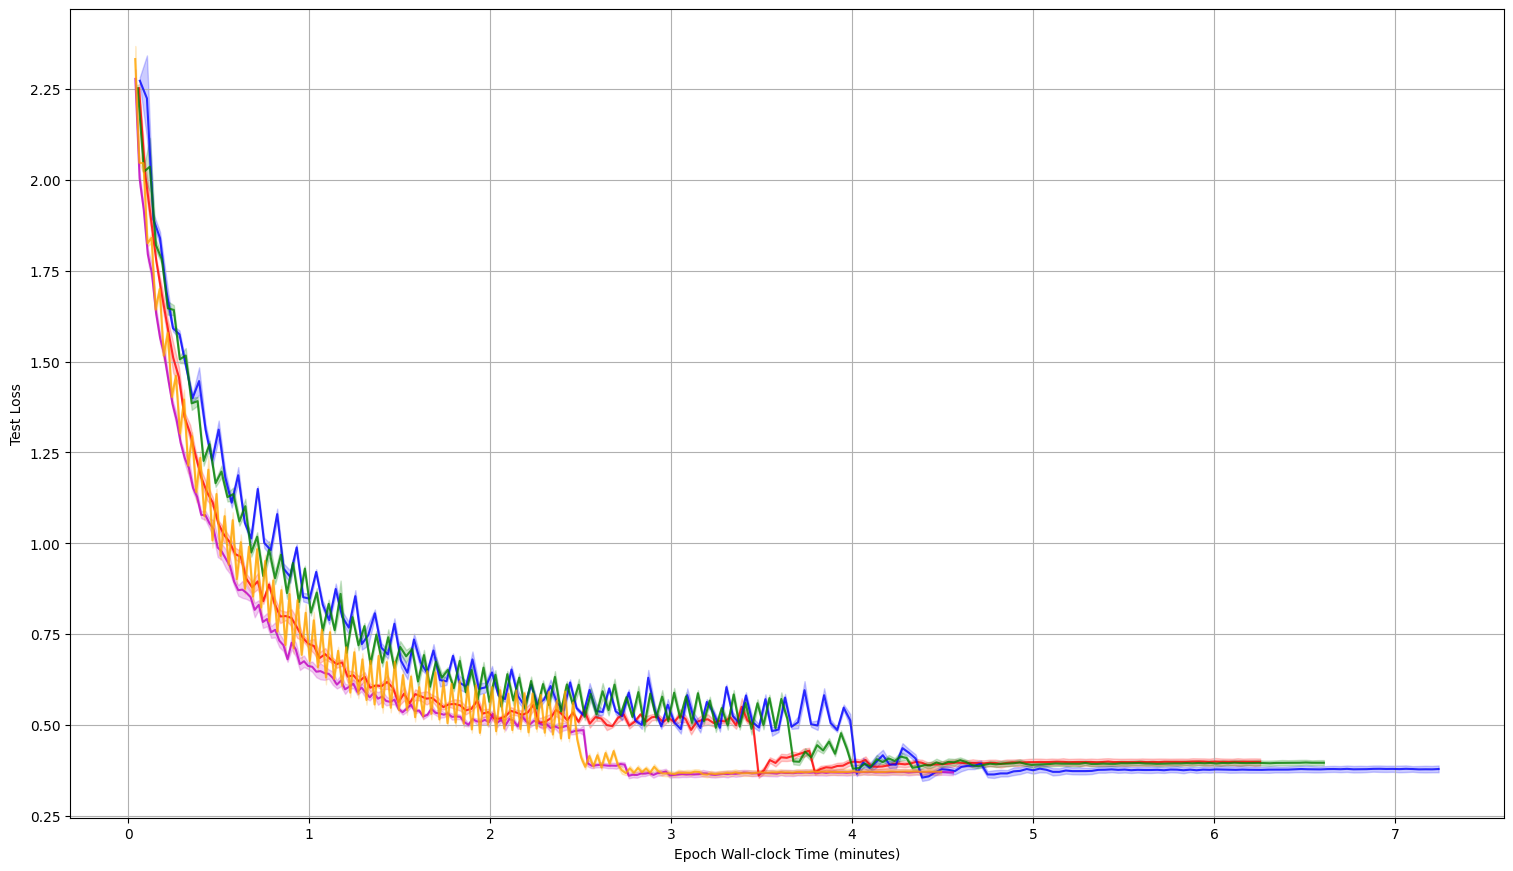

In [68]:
colors = ['r', 'b', 'g', 'm', 'orange', 'pink', 'cyan', 'yellow', 'purple']
ntest = 5
slowdowns = ["noslowdown", "slowdown2", "slowdown4"]


# exp_type defines:
# 0: it is ignored here
# 1: what graph topology (ring, clique-ring, 2c-clique-ring, 4c-clique-ring)
# 2: degree of noniidness or slowdown (noniid-0.25, noniid-0.9, noniid-0.7, noniid-0.5, iid, vary, noslowdown, slowdown2, slowdown4)
# 3: over which communication algorithms (all, dsgd)
# 4: this is for varying topology for 16 worker ring
exp_type = ["xxx", "ring", "iid", "all", "vary"]
# specify number of epochs
epochs = 200
# specify number of epochs to plot
plot_epochs = 200
# specify number of workers
num_work = 16

# specify which statistics to graph on the y-axis (will make separate plots)
stats = ["losses", "testloss"]


def dsgd_all_label_comm_label(et):
    if et[3] == "all":
        comm = ['dsgd', 'ldsgd', 'pdsgd', 'swift', '2swift']
        label = ['D-SGD', 'LD-SGD', 'PA-SGD', 'SWIFT', 'SWIFT (2-SGD)']
    elif et[3] == "dsgd":
        comm = ['dsgd', 'swift', '2swift']
        label = ['D-SGD', 'SWIFT', 'SWIFT (2-SGD)']
    else:
        print("BAD1")
    return comm, label

if exp_type[1] == "ring" and exp_type[2] == "iid":
    if exp_type[4] == "vary":
        base = f"Random-{num_work}-Ring-VT"
    else:
        base = f"Random-{num_work}-Ring"
elif exp_type[1] == "clique-ring" and exp_type[2][:6] == "noniid":
    base = f"Random-{num_work}-{exp_type[2][7:]}-Noniid"
elif exp_type[1] == "2c-clique-ring":
    base = f"Random-{num_work}-ROC/2Cluster"
elif exp_type[1] == "4c-clique-ring":
    base = f"Random-{num_work}-ROC/4Cluster"
elif exp_type[1] == "ring" and exp_type[2] in slowdowns:
    base = f"Slowdown-{num_work}-Ring"
else:
    print("BAD2")
   


for i in range(1):
    communicators, labels = dsgd_all_label_comm_label(exp_type)
    for s in stats:
        plt.clf()
        exp_type[0] = s
        ind = 0
        if exp_type[2] in slowdowns:
            for slow in slowdowns:
                exp_type[2] = slow
                communicators, labels = dsgd_all_label_comm_label(exp_type)

                for comm in communicators:
                    times = []
                    ys = []
                    for t in range(1, ntest + 1):
                        filename = f"Output/{base}/{comm}-{exp_type[2]}-test{t}-{num_work}W-{exp_type[1]}-1sgd-{epochs}epochs"
                        if exp_type[2] in slowdowns:
                            if comm == "swift":
                                filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-{exp_type[1]}-1sgd-{epochs}epochs"
                            elif comm == "2swift":
                                filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-{exp_type[1]}-2sgd-{epochs}epochs"
                        else:
                            if comm == "swift":
                                filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-no_mem-{exp_type[1]}-1sgd-{epochs}epochs"
                            elif comm == "2swift":
                                filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-no_mem-{exp_type[1]}-2sgd-{epochs}epochs"
                        loss = unpack_data(filename, datatype=f"{exp_type[0]}.log", epochs=epochs, num_workers=num_work)[:plot_epochs]
                        times_t = np.cumsum(
                            unpack_data(filename, datatype="total-time.log", epochs=epochs, num_workers=num_work) / 60, axis=0
                        )[:plot_epochs]

                        ys.append(loss.mean(axis=1))
                        times.append(times_t.mean(axis=1))
                    
                    times = np.stack(times, axis=0).mean(axis=0)
                    ys = np.stack(ys, axis=0)
                    y_mean, y_min, y_max = generate_confidence_interval(ys)

                    plt.plot(times, y_mean, label=labels[ind%len(labels)]+exp_type[2], alpha=0.8, color=colors[ind])
                    plt.fill_between(times, y_min, y_max, alpha=0.2, color=colors[ind])
                    
                    ind += 1
        else:
            for comm in communicators:
                times = []
                ys = []
                for t in range(1, ntest + 1):
                    filename = f"Output/{base}/{comm}-{exp_type[2]}-test{t}-{num_work}W-{exp_type[1]}-1sgd-{epochs}epochs"
                    if exp_type[2] == "noniid-0.5":
                            filename = f"Output/{base}/{comm}-noniid-test{t}-{num_work}W-{exp_type[1]}-1sgd-{epochs}epochs"
                    if exp_type[2] in slowdowns:
                        if comm == "swift":
                            filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-{exp_type[1]}-1sgd-{epochs}epochs"
                        elif comm == "2swift":
                            filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-{exp_type[1]}-2sgd-{epochs}epochs"
                    else:
                        if comm == "swift":
                            filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-no_mem-{exp_type[1]}-1sgd-{epochs}epochs"
                            if exp_type[2] == "noniid-0.5":
                                filename = f"Output/{base}/swift-noniid-test{t}-{num_work}W-no_mem-{exp_type[1]}-1sgd-{epochs}epochs"
                        elif comm == "2swift":
                            filename = f"Output/{base}/swift-{exp_type[2]}-test{t}-{num_work}W-no_mem-{exp_type[1]}-2sgd-{epochs}epochs"
                            if exp_type[2] == "noniid-0.5":
                                filename = f"Output/{base}/swift-noniid-test{t}-{num_work}W-no_mem-{exp_type[1]}-2sgd-{epochs}epochs"
                    loss = unpack_data(filename, datatype=f"{exp_type[0]}.log", epochs=epochs, num_workers=num_work)[:plot_epochs]
                    times_t = np.cumsum(
                        unpack_data(filename, datatype="epoch-time.log", epochs=epochs, num_workers=num_work) / 60, axis=0
                    )[:plot_epochs]

                    # average across all n workers
                    ys.append(loss.mean(axis=1))
                    times.append(times_t.mean(axis=1))
                
                times = np.stack(times, axis=0).mean(axis=0)
                ys = np.stack(ys, axis=0)
                y_mean, y_min, y_max = generate_confidence_interval(ys)

                plt.plot(times, y_mean, label=labels[ind], alpha=0.8, color=colors[ind])
                plt.fill_between(times, y_min, y_max, alpha=0.2, color=colors[ind])
                
                ind += 1

        plt.xlabel('Epoch Wall-clock Time (minutes)')
        if exp_type[0] == 'losses':
            y_label = 'Training Loss'
        else:
            y_label = 'Test Loss'

        #plt.ylabel(f'{exp_type[0]}')
        #plt.title(f'Average {exp_type[0]} Across Clients in {exp_type[1]} Topology (on {exp_type[2]} data), {plot_epochs} epch' + f",{num_work} work")
        # plt.legend()
        plt.ylabel(y_label)
        plt.grid()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        tikzplotlib.save(f"{exp_type[3]}vsswift-{exp_type[0]}-{exp_type[1]}-{exp_type[2]}-{num_work}w.tex")
        plt.show()
        # plt.savefig("everythingswiftnoniid.pdf", format="pdf")